<a href="https://colab.research.google.com/github/EddyGiusepe/Overfitting_and_Regularization/blob/main/Regularization_for_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Overfitting e Regularização</h2>


Data Scientist: Dr.Eddy Giusepe Chirinos Isidro

# Regularization

Como temos percebido, quando treinamos Redes Neurais corremos o risco de fazer `OVERFITTING` aos Dados de Treinamento, o qual será traduzido em uma má performance de nosso modelo quando receba Dados que nunca haja visto (ou seja não haverá GENERALIZADO). A melhor maneira de saber se nosso modelo tem Overfitting é observando as Curvas de Treinamento (<font color="orange">ver o gráfico a seguir</font>).

Neste script vamos treinar uma `MLP` no Dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) para classificação de imagens em $10$ classes diferentes.

![](https://hidden.brutalk.com/wp-content/uploads/2021/02/1614208808_358_How-to-use-Learning-Curves-to-Diagnose-Machine-Learning-Model.png)

Usaremos a biblioteca `torchvision` para descarregar o Dataset. 

Este Dataset está formado por imagens em cor de baixa resolução, temos $50000$ imagens de Treinamento e $10000$ de teste. O objetivo é classificar em $10$ classes diferentes. Vejamos alguns exemplos:

In [1]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(50000, 10000)

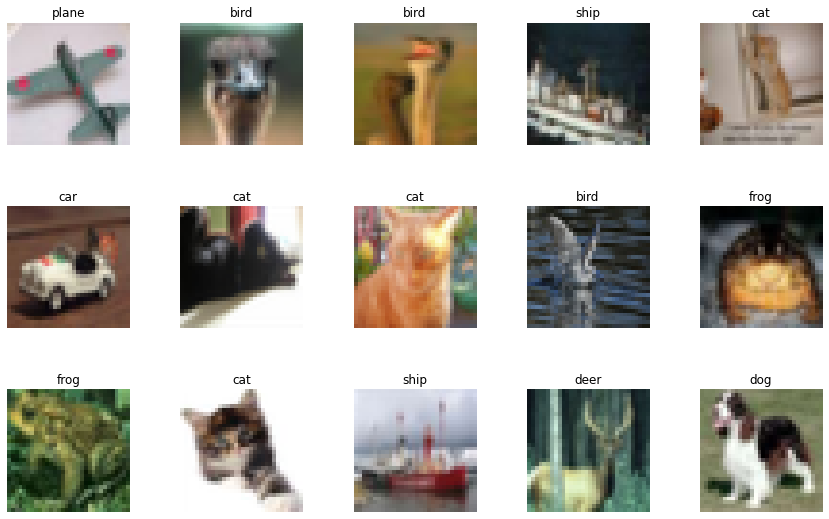

In [2]:
import random 
import matplotlib.pyplot as plt
%matplotlib inline

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

A seguir vamos a transformar as imagens em `arrays` de `NumPy` para poder trabalhar com elas mais facilmente.

In [3]:
import numpy as np


train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]


X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

Agora, podemos aplicar de forma similar o código para treinar um [The Multilayer Perceptron](https://github.com/EddyGiusepe/Perceptron_with_Python/blob/main/The_Multilayer_Perceptron_(MLP)_.ipynb), e assim poder observar as curvas de Treinamento.

In [4]:
import torch



class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [5]:
from sklearn.metrics import accuracy_score



def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()


def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [6]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 1.71914 acc 0.37201 val_loss 1.88674 val_acc 0.32800
Epoch 20/100 loss 1.51546 acc 0.44904 val_loss 2.51549 val_acc 0.26640
Epoch 30/100 loss 1.33384 acc 0.51373 val_loss 2.39273 val_acc 0.29560
Epoch 40/100 loss 1.15592 acc 0.57862 val_loss 2.12982 val_acc 0.36360
Epoch 50/100 loss 1.01286 acc 0.62998 val_loss 2.90279 val_acc 0.31900
Epoch 60/100 loss 0.87061 acc 0.68412 val_loss 3.11014 val_acc 0.33170
Epoch 70/100 loss 0.75512 acc 0.71935 val_loss 3.44180 val_acc 0.33720
Epoch 80/100 loss 0.77556 acc 0.72074 val_loss 4.02966 val_acc 0.29780
Epoch 90/100 loss 0.60183 acc 0.78662 val_loss 3.63567 val_acc 0.36150
Epoch 100/100 loss 0.52808 acc 0.81429 val_loss 7.13518 val_acc 0.28830


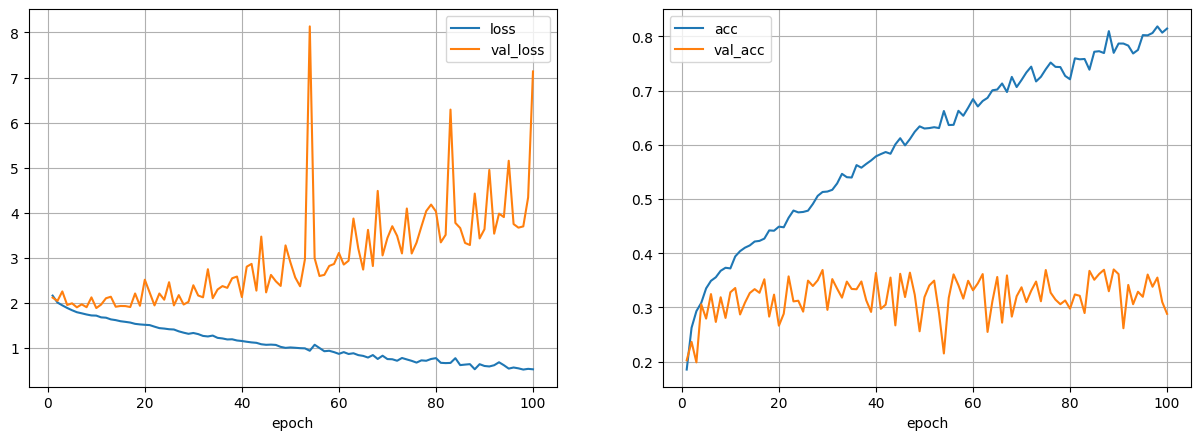

In [7]:
import pandas as pd

fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar nas curvas de Treinamento, as métricas para o conjunto de Dados de `Treinamento` vão melhorando epoch tras epoch, no entanto as métricas de `validação` rapidamente se estancam e começam a piorar. Isto é um sinal claro de que nosso Modelo está sofrendo de `Overfitting`.


Seguidamente estudaremos as diferentes técnicas de `REGULARIZAÇÃO`, o término técnico utilizado para referirmos às diferentes técnicas de redução de Overfitting.

# Regularização $L2$

Esta técnica é muito usada. Esta técnica consiste em penalizar (restringuir) a magnitude dos pesos da `Rede Neural`, forçando-os a ser valores pequenos. Para efeitos práticos, a `REGULARIZAÇÃO L2` se implementa como um término extra na Função de Perda, assim:


$$ l = CE(\hat{y}, y) + \alpha \frac{1}{2} || \mathbf{w} || $$


onde $CE(\hat{y}, y)$ é a função `Cross Entropy` (ou qualquer outra função de perda, dependendo da tarefa que estes realizando), $\mathbf{w}$ são os pesos da rede e $α$ é um parâmetro que indica quanto queremos regularizar o modelo. Em `Pytorch` podemos adicionar o valor de $α$ através do parâmetro `weight_decay` diretamente no otimizador (<font color="orange">por dafault é $0$</font>). Valores típicos usados estão no intervalo de $[0.001, 0.01]$. 

In [8]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.05)

Epoch 10/100 loss 2.07423 acc 0.21517 val_loss 2.08616 val_acc 0.22930
Epoch 20/100 loss 2.07812 acc 0.21039 val_loss 2.05379 val_acc 0.19520
Epoch 30/100 loss 2.08944 acc 0.20999 val_loss 2.59819 val_acc 0.10620
Epoch 40/100 loss 2.08106 acc 0.21716 val_loss 2.34410 val_acc 0.12740
Epoch 50/100 loss 2.07157 acc 0.21537 val_loss 2.09383 val_acc 0.20680
Epoch 60/100 loss 2.08128 acc 0.20641 val_loss 2.11205 val_acc 0.18180
Epoch 70/100 loss 2.07617 acc 0.21119 val_loss 2.43211 val_acc 0.12530
Epoch 80/100 loss 2.08454 acc 0.20900 val_loss 2.76937 val_acc 0.10590
Epoch 90/100 loss 2.07594 acc 0.21457 val_loss 2.11435 val_acc 0.20900
Epoch 100/100 loss 2.07961 acc 0.21079 val_loss 2.23642 val_acc 0.14840


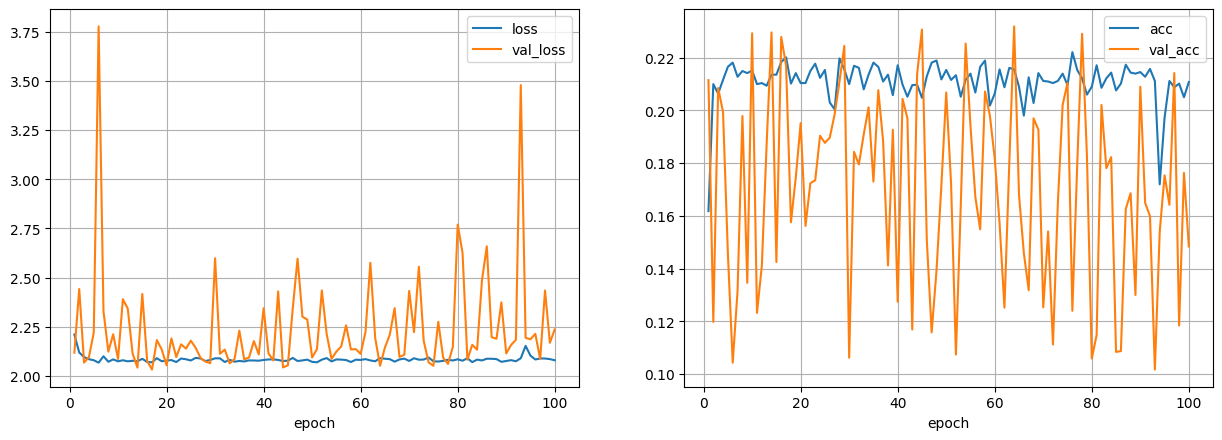

In [9]:
#fig = plt.figure(dpi=200, figsize=(10,3))
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

como podemo observar, agora, as curvas de Treinamento e Validação estão mais próximas (`as curvas Loss`), pelo que precebimos que conseguimos diminuir o Overfitting. <font color="orange">É importante dizer que reduzir o `Overfitting` não implica melhorar as métricas (o grafico de accuracy)</font>. 

# Early Stopping

Esta é outra técnica utilizada para regularizar um modelo. Esta técnica consiste em levar um registro das métricas de Validação durante o Treinamento, salvar os pesos do modelo cada vez que as métricas melhoram e, uma vez que termina o treinamento, carregar os melhores pesos invés de ficar com os últimos. De forma opcional também podemos deter o treinamento se em caso não melhora as nossas métricas durante um determinado número de epochs seguidas, o qual podemos traduzir numa economia de tempo e computo.

In [10]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [11]:
model = build_model()

hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.12200 en epoch 1
Mejor modelo guardado con acc 0.18340 en epoch 2
Mejor modelo guardado con acc 0.22780 en epoch 3
Mejor modelo guardado con acc 0.28810 en epoch 4
Mejor modelo guardado con acc 0.29440 en epoch 10
Epoch 10/100 loss 1.71989 acc 0.37759 val_loss 2.04144 val_acc 0.29440
Mejor modelo guardado con acc 0.29590 en epoch 12
Mejor modelo guardado con acc 0.35180 en epoch 13
Epoch 20/100 loss 1.48279 acc 0.46576 val_loss 2.72891 val_acc 0.24130
Entrenamiento detenido en epoch 23 por no mejorar en 10 epochs seguidas


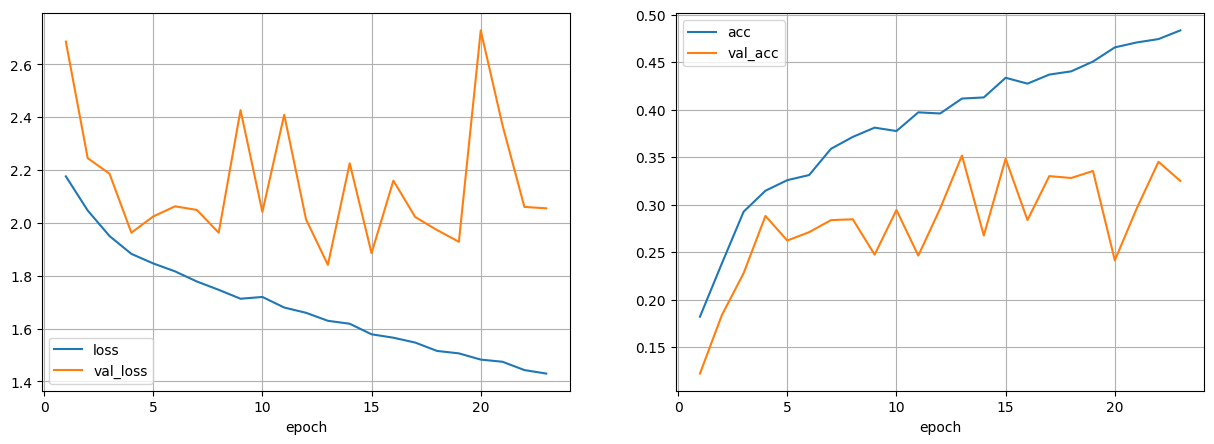

In [12]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Comparando esta figura com a primeira, podrás observar que se continuamos treinando com mais epochs não vamos obter um bom modelo. Por tanto, não é necessário seguir treinando, já que encontramos o melhor modelo possível dada as circustâncias. `Early Stopping` é uma técnica muito simples e efetiva, pelo que é recomendável usá-la sempre.  


> 💡 Dá uma olhada no `Pytorch`, para aprender a como salvar e carregar modelos [click aqui](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

# Dropout

Outra técnica muito popular para reduzir o `Overfitting` é o uso do `Dropout`. Esta técnica se implementa como uma camada extra a nossa Rede Neural cujo objetivo é, durante o Treinamento, "apagar" de maneira aleatória alguns neurônios de maneira que forçamos a nosso modelo a aprender diferentes caminhos dentro da arquitetura para representar os mesmos Dados. 

![](https://www.researchgate.net/profile/Yifan-Zhang-16/publication/332450026/figure/fig5/AS:748477176885249@1555462273508/Neural-network-with-dropout.png)

In [13]:
# Podemos ver a camada extra: "Dropout" 

def build_model(D_in=32*32*3, H=100, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

Podemos adicionar uma camada de Dropout com a classe `torch.nn.Dropout`. O parâmetro `p` controla a probabilidade de "apagar" uma neurona. Este valor coincide com a proporção (em promédio) de neuronas que serão anuladas numa camada determinada. 


> ⚡ Quando não estamos treinando, geralmente não desejamos que a capa Dropout esté ativa de maneira que utilicemos todas as  Neuronas no Modelo. Podemos controlar o modo como trabalha a camada chamando às funções `model.train()` e `model.eval()`, as quais serão responsáveis pela atribuição do modo adequado à camada Dropout (e qualquer outra camada de tua Rede que também tenha diferente comportamento segundo estemos Treinando ou Avaliando o Modelo). Isto é muito importante e fonte comum de erros ao trabalhar com `Pytorch`.

In [14]:
model = build_model(p=0.5)

hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.16280 en epoch 1
Mejor modelo guardado con acc 0.21490 en epoch 3
Mejor modelo guardado con acc 0.22960 en epoch 5
Mejor modelo guardado con acc 0.23540 en epoch 8
Epoch 10/100 loss 2.08025 acc 0.19984 val_loss 2.09142 val_acc 0.21340
Mejor modelo guardado con acc 0.26740 en epoch 18
Epoch 20/100 loss 2.02104 acc 0.23109 val_loss 2.04703 val_acc 0.22920
Mejor modelo guardado con acc 0.26860 en epoch 23
Mejor modelo guardado con acc 0.27020 en epoch 26
Mejor modelo guardado con acc 0.27610 en epoch 28
Epoch 30/100 loss 2.00093 acc 0.24781 val_loss 2.00732 val_acc 0.23300
Mejor modelo guardado con acc 0.28270 en epoch 35
Epoch 40/100 loss 1.97902 acc 0.24821 val_loss 1.93610 val_acc 0.27500
Mejor modelo guardado con acc 0.29010 en epoch 42
Epoch 50/100 loss 1.93851 acc 0.26692 val_loss 1.95674 val_acc 0.25350
Mejor modelo guardado con acc 0.29310 en epoch 57
Epoch 60/100 loss 1.95892 acc 0.25916 val_loss 1.99409 val_acc 0.24330
Epoch 70/100 loss 1.93178 ac

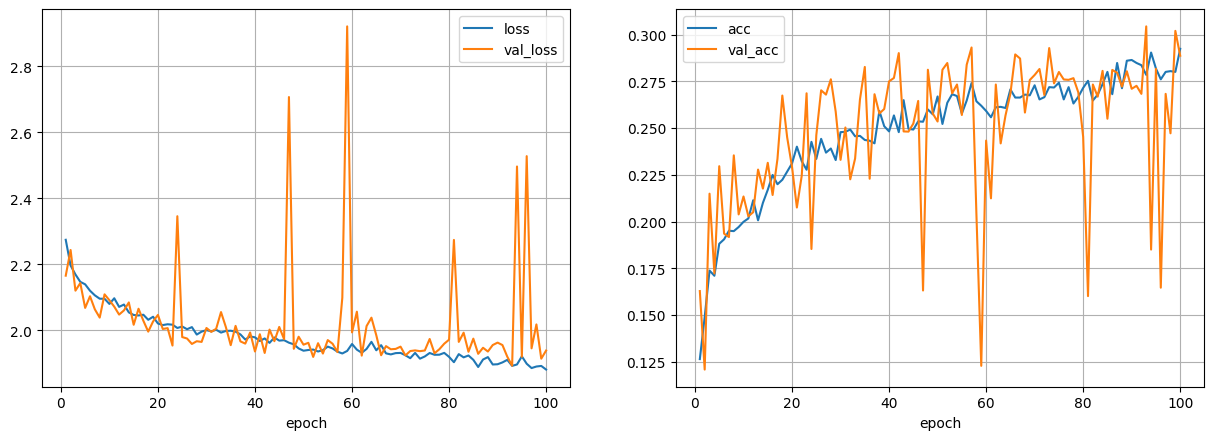

In [15]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Mais uma vez observamos que as curvas de Treinamento já não apresentam Overfitting. Podemos brincar um pouco com a Probabilidade de Dropout para controlar seu efeito no resultado final. De novo, reparemos que reduzir o Overfitting não implica necessariamente que nosso modelo tenha melhores métricas, simplesmente estamos forçando ao modelo a não `aprender a memorizar` o Dataset de treinamento.

# Usar mais Dados

A melhor maneira de reduzir o Overfitting é usando mais Dados. Isto é um fato obvio, mas não é simples de conseguir já que obter um maior Dataset não é sempre fatível e geralmente sempre usamos todos os Dados que temos a nossa disposição. No entanto, a diferença do resto de estrategias apresentadas até agora, ésta não só reduzirá o Overfitting senão que também melhorará as métricas de nosso modelo.

In [16]:
# Agora sim que usamos todos os Dados

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [17]:
model = build_model()

hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.26470 en epoch 1
Mejor modelo guardado con acc 0.32910 en epoch 2
Mejor modelo guardado con acc 0.39100 en epoch 3
Mejor modelo guardado con acc 0.40430 en epoch 4
Mejor modelo guardado con acc 0.41240 en epoch 5
Mejor modelo guardado con acc 0.44080 en epoch 7
Mejor modelo guardado con acc 0.44600 en epoch 9
Epoch 10/100 loss 1.48172 acc 0.46425 val_loss 1.62450 val_acc 0.43170
Mejor modelo guardado con acc 0.45940 en epoch 12
Mejor modelo guardado con acc 0.46090 en epoch 13
Mejor modelo guardado con acc 0.47280 en epoch 18
Mejor modelo guardado con acc 0.47380 en epoch 20
Epoch 20/100 loss 1.36560 acc 0.50895 val_loss 1.50884 val_acc 0.47380
Mejor modelo guardado con acc 0.47540 en epoch 30
Epoch 30/100 loss 1.29678 acc 0.53277 val_loss 1.56604 val_acc 0.47540
Mejor modelo guardado con acc 0.48490 en epoch 33
Mejor modelo guardado con acc 0.48630 en epoch 37
Epoch 40/100 loss 1.23333 acc 0.55460 val_loss 1.56334 val_acc 0.48130
Entrenamiento detenido 

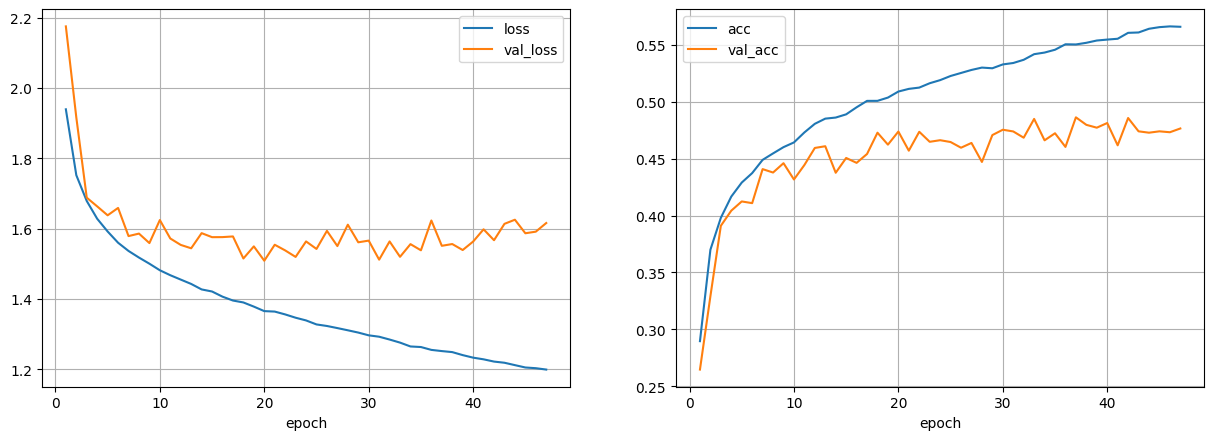

In [18]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar a métrica de nosso modelo se a incrementado consideravelmente graças ao uso de mais Dados. Desta maneira aproveitamos mais a capacidade do modelo.

# Data Augmentation

Como não sempre é fácil conseguir mais Dados, podemos aplicar a seguinte ideia: invés de fornecer ao modelo sempre nossas imagens na mesma maneira, vamos aplicar transformações de maneira aleatória de forma que, efetivamente, nosso modelo não veja nunca a mesma imagem duas vezes, conseguindo assim um Dataset potencialmente infinito. Estas transformações devem alterar a imagem o suficiente como para poder considerá-la como uma amostra diferente mas não muito como para alterar sua etiqueta. Alguns exemplos destas transformações incluem: `giros`, `recortes`, `alterações de cor`, `brilho` ou `tamanho`, etc.

Existem muitas ferramentas disponíveis para aplicar transformações a imagens (por exemplo a mesma biblioteca de `torchvision` inclue algumas). Uma eleção popular é a biblioteca [albumentations](https://github.com/albumentations-team/albumentations).

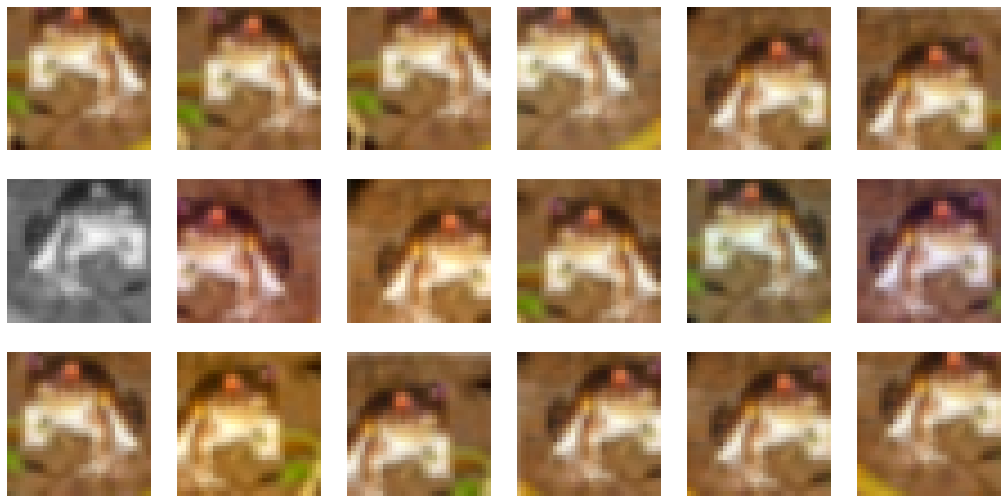

In [19]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

# Com este Compose você pode passar uma lista para que faça as transformações que você quer que ser apliquem
trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

idx = 0
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img, label = trainset[idx]
        # apply transformation
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

Na figura anterior estamos visualizando uma única amostra de nosso Dataset à qual aplicamos uma série de transformações que tem alterado sua apariência sem modificar sua Label (etiqueta). Aplicando éstas transformações aleatórias a cada amostra antes de fornecer à `Red Neuronal` obrigará a nosso modelo a GENERALIZAR muito mais, reduzindo o Overfitting. 

In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().cuda().view(-1)
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label

dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [21]:
model = build_model()

hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.30410 en epoch 1
Mejor modelo guardado con acc 0.32880 en epoch 2
Mejor modelo guardado con acc 0.34410 en epoch 4
Mejor modelo guardado con acc 0.36910 en epoch 5
Mejor modelo guardado con acc 0.38930 en epoch 9
Epoch 10/100 loss 1.82044 acc 0.33530 val_loss 1.74195 val_acc 0.38050
Mejor modelo guardado con acc 0.39180 en epoch 13
Mejor modelo guardado con acc 0.39250 en epoch 15
Mejor modelo guardado con acc 0.40800 en epoch 17
Epoch 20/100 loss 1.75560 acc 0.36068 val_loss 1.70974 val_acc 0.39890
Mejor modelo guardado con acc 0.40830 en epoch 27
Mejor modelo guardado con acc 0.41390 en epoch 28
Mejor modelo guardado con acc 0.41760 en epoch 29
Mejor modelo guardado con acc 0.42290 en epoch 30
Epoch 30/100 loss 1.72651 acc 0.37617 val_loss 1.61761 val_acc 0.42290
Epoch 40/100 loss 1.70546 acc 0.38185 val_loss 1.67290 val_acc 0.40330
Mejor modelo guardado con acc 0.42740 en epoch 44
Epoch 50/100 loss 1.70242 acc 0.38388 val_loss 1.61788 val_acc 0.41810


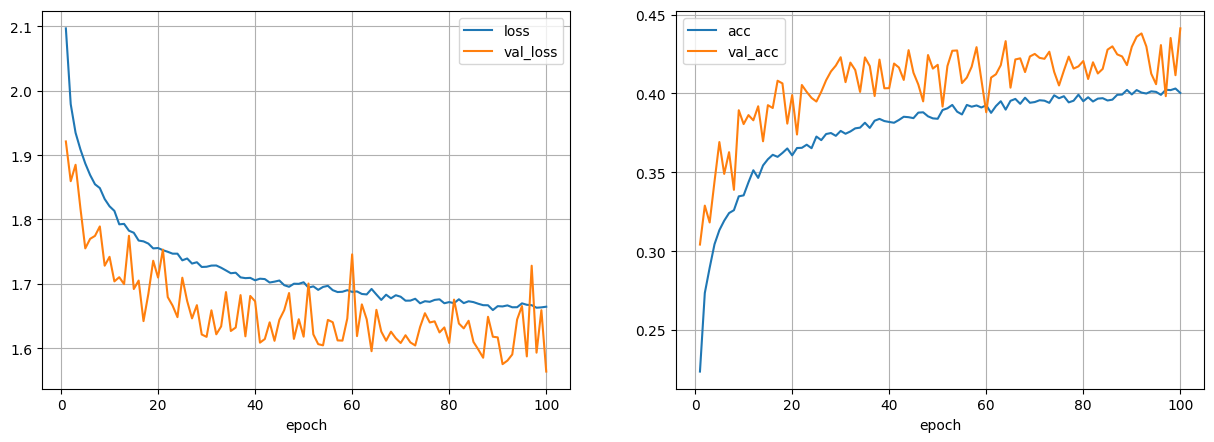

In [22]:
fig = plt.figure(dpi=100, figsize=(15,5))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

O uso de Data Augmentation requer de um Treinamento mais longo para poder aproveitar toda a capacidade que as TRANSFORMAÇÕES nos oferece. Uma característica interessante desta técnica é que podemos conseguir que as curvas de aprendizagem de Validação estém por acima das de treinamento, indicando que nosso modelo realmente trabalha melhor em Dados não vistos (o qual não significa necessariamente que o modelo seja melhor, neste caso por exemplo nossas MÉTRICAS não são tão boas como no caso anterior).

OBS:

<font color="orange">O uso de Early Stopping e Data Augmentation (quando trabalhamos com imagens) são de uso praticamente obrigatório. A efetividade do resto de técnicas dependerá de teu caso, mas sempre é recomendável testar para avaliar seu potencial.</font>